##### QRF_3: Purely time series - all ordinal variables: year, month, weekday, hour and (not ordinal) count

In [1]:
# Path setup
import sys
import os

sys.path.append("/home/dchen/Random_Forest_Weights/")

# Basics:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Helpful:
from sklearn.model_selection import train_test_split

# Pipeline and ColumnsTransformer:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# models:
import statsmodels.api as sm

# my functions:
from src_rf.methods.calc_mean import *
from src_rf.methods.calc_weights import *
from src_rf.methods.calc_dist import *
from src_rf.datasets.qrf_3.load_weights_qrf_3 import * 
from src_rf.datasets.qrf_3.load_specific_weights_qrf_3 import * 
from src_rf.methods.filter_weights_rf import * 
from src_rf.methods.filter_specific_weights_rf import * 

### 0. Setup

In [2]:
dir_path = "/Data/Delong_BA_Data/rf_weights/qrf_3/"

In [3]:
batch_size = 500

### 1. Load Data, Modify and Split

In [4]:
df = pd.read_csv("/home/dchen/Random_Forest_Weights/src_rf/data/energy_data_hourly.csv"
                 , index_col = 'datetime', parse_dates=True)

df.drop(['residual_energy_usage', 'pump_storage'], inplace = True, axis =  1)
# Extract the year from the index
df['Year'] = df.index.year
# 1. Extract weekday name
df['weekday'] = df.index.day_name()

# 2. Ordinal encode 'hour', 'weekday', 'month', and 'Year'
# (In this case, 'hour', 'month', and 'Year' are already ordinal, so just encoding 'weekday')
weekday_ordering = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df['weekday'] = df['weekday'].astype(pd.CategoricalDtype(categories=weekday_ordering, ordered=True))
df['weekday'] = df['weekday'].cat.codes

# No need to change the 'Year' column as you want it in ordinal form

# 3. Add a count variable
df['Count'] = range(df.shape[0])

# Drop unnecessary columns
columns_to_drop = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
df.drop(columns=columns_to_drop, inplace=True)
    
df['Count'] = range(0, df.shape[0])

In [5]:
X = df.drop('total_energy_usage', axis = 1)
y = df['total_energy_usage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3 ,shuffle=False, random_state=42)

### 2. Load qrf_3 weights

#### 2.1 Test Date to look at

In [42]:
test_date = 1080

In [44]:
qrf_3_weights= load_specific_weights_qrf_3(dir_path, test_date)

### 3. Weight Exploration

In [45]:
print(X_test.iloc[test_date, 0:])

hour          16
month          7
Year        2020
weekday        6
Count      48808
Name: 2020-07-26 16:00:00, dtype: int64


#### 3.2 Load Weights

In [46]:
qrf_3_weight_0 = filter_specific_weight_rf(qrf_3_weights , test_date, batch_size)
qrf_3_weight_0.sum()

0.9999999999999999

#### 3.3 Non-Zero Values

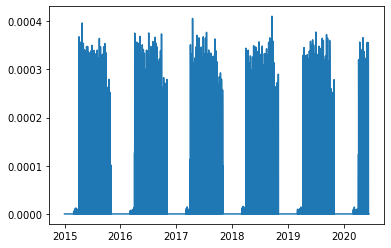

In [47]:
plt.plot(X_train.index, qrf_3_weight_0)
plt.show()

In [48]:
non_zeros =  np.where(qrf_3_weight_0 != 0)[0]

In [49]:
print('Year:')
print(X_train.iloc[non_zeros, :].index.year.value_counts().sort_values(ascending = False))
print(100 * '-')

print('Month:')
print(X_train.iloc[non_zeros, :].index.month.value_counts().sort_values(ascending = False))
print(100 * '-')

print('Week day:')
# Here, weekday gives a number where 0 is Monday and 6 is Sunday. We then map these numbers to their string names.
print(X_train.iloc[non_zeros, :].index.weekday.map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
      .value_counts().sort_values(ascending = False))
print(100 * '-')

print('Hour:')
print(X_train.iloc[non_zeros, :].index.hour.value_counts().sort_values(ascending = False))

Year:
2016    1108
2017    1107
2015    1103
2018    1101
2019    1096
2020     429
Name: datetime, dtype: int64
----------------------------------------------------------------------------------------------------
Month:
5     875
4     858
7     743
6     742
9     726
10    726
8     709
3     565
Name: datetime, dtype: int64
----------------------------------------------------------------------------------------------------
Week day:
Sunday      3114
Saturday    2830
Name: datetime, dtype: int64
----------------------------------------------------------------------------------------------------
Hour:
22    367
13    365
23    365
17    364
15    363
10    362
16    362
21    362
14    361
12    360
9     360
11    360
19    358
20    358
18    355
8     343
7     179
Name: datetime, dtype: int64
